In [114]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.datasets import dump_svmlight_file
from sklearn.datasets import load_svmlight_file
import sklearn.svm.libsvm as libsvm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn_evaluation import plot
from random import shuffle
import warnings
warnings.filterwarnings('ignore')

In [108]:
#method to split the train and test set 
def train_test(X,y):
    indices = np.arange(X.shape[0])
    shuffle(indices)
    X_shuffled=X[list(indices)]
    y_shuffled=y[list(indices)]
    train_X = X_shuffled[:int(0.7*X.shape[0])]
    train_Y = y_shuffled[:int(0.7*X.shape[0])]
    test_X = X_shuffled[int(0.7*X.shape[0]):]
    test_Y = y_shuffled[int(0.7*X.shape[0]):]
    return train_X,train_Y,test_X,test_Y

In [100]:
def libSVM(data, path):
    """<label><index>:<value>"""
    with open(path, 'a') as file:
        for _,row in data.iterrows():
            #label 
            contentString = str(row[max(rating_data.columns)])
            for col in range(0,max(data.columns)):
                if(row[col]!=0):
                    contentString=contentString+" "+str(col)+":"+str(row[col]) #index:value
            #print(contentString)
            contentString=contentString+"\n"
            file.write(contentString)

In [161]:
#in case we wish to load the column names for the words
with open(r'D:\Exercises\ML Lab\colnames.txt') as f:
    content = f.readlines()
content = [re.sub(':', '', x.strip()) for x in content] 
#read the data
freq_data =  pd.read_csv(r'D:\Exercises\ML Lab\spambase.data', sep=',',header = None,index_col=False)
freq_data.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


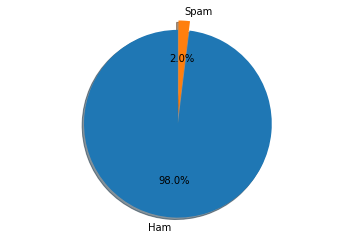

In [172]:
y = freq_data.iloc[57]
#class distribution of Spam Ham 
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie([(y == 0).sum(),(y == 1).sum()], explode=explode, labels=['Ham','Spam'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Plot a pie chart to describe the data we have 

plt.show()

#### We can see that spam class has very low representation, naturally even worst of all our model will given 98% accuracy due to poor class representation, hence we need to focus on precision to evaluate our model.

In [99]:
#save the data into test.dat file
libSVM(freq_data,"test.dat")
#the format rendered by our function 

1.0 1:0.64 2:0.64 4:0.32 11:0.64 15:0.32 17:1.29 18:1.93 20:0.96 51:0.778 54:3.7560000000000002 55:61.0 56:278.0
1.0 0:0.21 1:0.28 2:0.5 4:0.14 5:0.28 6:0.21 7:0.07 9:0.94 10:0.21 11:0.79 12:0.65 13:0.21 14:0.14 15:0.14 16:0.07 17:0.28 18:3.47 20:1.59 22:0.43 23:0.43 36:0.07 49:0.132 51:0.37200000000000005 52:0.18 53:0.048 54:5.114 55:101.0 56:1028.0
1.0 0:0.06 2:0.71 4:1.23 5:0.19 6:0.19 7:0.12 8:0.64 9:0.25 10:0.38 11:0.45 12:0.12 14:1.75 15:0.06 16:0.06 17:1.03 18:1.36 19:0.32 20:0.51 22:1.16 23:0.06 39:0.06 42:0.12 44:0.06 45:0.06 48:0.01 49:0.14300000000000002 51:0.276 52:0.184 53:0.01 54:9.821 55:485.0 56:2259.0


In [104]:
#scikit method to load the lightSVM format
X,y = load_svmlight_file("test.dat")
#loading the file we created using load_svmlight_file into data and response
X.shape,freq_data.shape

((4601, 57), (4601, 58))

#### Libsvm format contains one less column of our response variable

### Train the SVC over grid of HPs

In [141]:
#split the data in train and test
train_x,train_y,test_x,test_y = train_test(X,y)
#range of hyperparameters
list_C = np.arange(1, 1500, 10) #100000
#create a list to store the all the score
score_train = np.zeros(len(list_C))
score_test = np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))
logloss_test= np.zeros(len(list_C))
count = 0
for C in list_C:
    #create the model and fit using C values
    svc = SVC(C=C)
    svc.fit(train_x, train_y)
    #evaluate the metrics
    score_train[count] = svc.score(train_x, train_y)
    score_test[count]= svc.score(test_x, test_y)
    predicted = svc.predict(test_x)
    recall_test[count] = metrics.recall_score(test_y, predicted)
    precision_test[count] = metrics.precision_score(test_y, predicted)
    logloss_test[count] = log_loss(test_y, predicted)
    count = count + 1 

In [142]:
#create a matrix for our analysis 
np.c_[list_C, score_train, score_test, recall_test, precision_test,logloss_test].shape

(150, 6)

In [143]:
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test,logloss_test])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision','Log loss'])
models.head(n=10)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision,Log loss
0,1.0,0.946584,0.818972,0.778598,0.764493,6.252569
1,11.0,0.992857,0.838523,0.808118,0.786355,5.577293
2,21.0,0.996894,0.839247,0.815498,0.783688,5.552285
3,31.0,0.996894,0.838523,0.817343,0.781305,5.577296
4,41.0,0.997205,0.837075,0.813653,0.780531,5.627316
5,51.0,0.997516,0.837799,0.815498,0.780919,5.602306
6,61.0,0.997516,0.838523,0.815498,0.782301,5.577296
7,71.0,0.997516,0.837075,0.813653,0.780531,5.627316
8,81.0,0.997516,0.837799,0.811808,0.782918,5.602305
9,91.0,0.997516,0.837799,0.811808,0.782918,5.602305


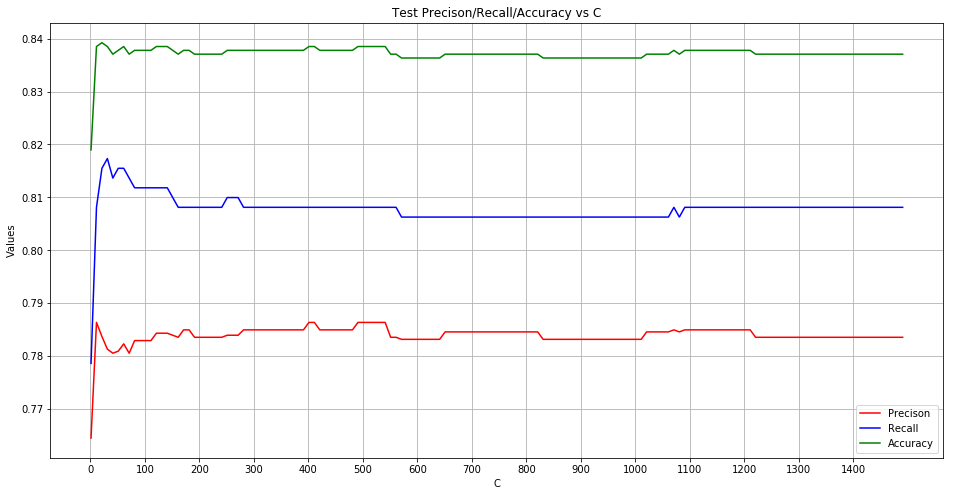

In [160]:
#here we look into our plot for 3 parameter against the values of C
plt.figure(figsize = (16, 8))
plt.plot(models['C'],models['Test Precision'],'-r'
         ,models['C'],models['Test Recall'],'-b'
        ,models['C'],models['Test Accuracy'],'-g')
plt.title("Test Precison/Recall/Accuracy vs C")
plt.grid()
plt.xlabel('C')
plt.ylabel('Values')
plt.xticks(np.arange(0, 1500, 100))
plt.legend(['Precison','Recall','Accuracy'])

### In a spam classifier, if a non-spam message is classified as spam it can cause huge damage and should be considered as an extreme case. This category of missclassification is measured using Precision (includes False Positive), thus I have considered Precision as a metric for deciding our best classifier value

In [154]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

C                 11.000000
Train Accuracy     0.992857
Test Accuracy      0.838523
Test Recall        0.808118
Test Precision     0.786355
Log loss           5.577293
Name: 1, dtype: float64

In [155]:
#we use our best C value for further classifying
svc = SVC(C=11)
svc.fit(train_x, train_y)
models.iloc[best_index, :]

C                 11.000000
Train Accuracy     0.992857
Test Accuracy      0.838523
Test Recall        0.808118
Test Precision     0.786355
Log loss           5.577293
Name: 1, dtype: float64

### Therefore our model yields Precision of 78% while Recall and Accuracy are around 80% on test set.